In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import numpy as np

device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu') 


In [14]:
# Set random seed
seed = 101
torch.manual_seed(seed)
np.random.seed(seed)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Memory:
    def __init__(self, capacity=5e5):
        self.storage = []
        self.capacity = int(capacity)
        self.index = 0
    
    def add(self, data):
        self.index += 1
        self.storage.append(data)
    
    def sample(self, batch_size):
        if self.index > self.capacity:
            del self.storage[0:int(self.index/5)]
            self.index = len(self.storage)
        
        indexes = np.random.randint(0, len(self.storage), size=batch_size)
        observation, act, r, next_observation, d = [], [], [], [], []
        
        for i in indexes:
            obs, a, reward, next_obs, done = self.storage[i]
            observation.append(np.array(obs, copy=False))
            act.append(np.array(a, copy=False))
            r.append(np.array(reward, copy=False))
            next_observation.append(np.array(next_obs, copy=False))
            d.append(np.array(done, copy=False))
        
        return np.array(observation), np.array(act), np.array(r), np.array(next_observation), np.array(d)

class Performer(nn.Module):
    def __init__(self, observation_dim, act_dim, max_act):
        super(Performer, self).__init__()
        
        self.layer1 = nn.Linear(observation_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, act_dim)
        
        self.max_act = max_act
        
    def forward(self, observation):
        x = F.relu(self.layer1(observation))
        x = F.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x)) * self.max_act
        return x

class Evaluator(nn.Module):
    def __init__(self, observation_dim, act_dim):
        super(Evaluator, self).__init__()
        
        self.layer1 = nn.Linear(observation_dim + act_dim, 400)
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, 1)
        
    def forward(self, observation, act):
        observation_act = torch.cat([observation, act], 1)
        
        val = F.relu(self.layer1(observation_act))
        val = F.relu(self.layer2(val))
        val = self.layer3(val)
        return val

class TripleDelayedDDPG:
    def __init__(self, alpha, observation_dim, act_dim, max_act):
        
        self.performer = Performer(observation_dim, act_dim, max_act).to(device)
        self.performer_target = Performer(observation_dim, act_dim, max_act).to(device)
        self.performer_target.load_state_dict(self.performer.state_dict())
        self.performer_optimizer = optim.Adam(self.performer.parameters(), lr=alpha)
        
        self.evaluator_1 = Evaluator(observation_dim, act_dim).to(device)
        self.evaluator_1_target = Evaluator(observation_dim, act_dim).to(device)
        self.evaluator_1_target.load_state_dict(self.evaluator_1.state_dict())
        self.evaluator_1_optimizer = optim.Adam(self.evaluator_1.parameters(), lr=alpha)
        
        self.evaluator_2 = Evaluator(observation_dim, act_dim).to(device)
        self.evaluator_2_target = Evaluator(observation_dim, act_dim).to(device)
        self.evaluator_2_target.load_state_dict(self.evaluator_2.state_dict())
        self.evaluator_2_optimizer = optim.Adam(self.evaluator_2.parameters(), lr=alpha)
        
        self.max_act = max_act
    
    def select_action(self, observation):
        observation = torch.FloatTensor(observation.reshape(1, -1)).to(device)
        return self.performer(observation).cpu().data.numpy().flatten()
    
    def improve(self, memory, steps, minibatch_size, disc_factor, tau, act_noise, noise_bound, delay_freq):
        
        for i in range(steps):
            observation, act_, r, next_observation, d = memory.sample(minibatch_size)
            observation = torch.FloatTensor(observation).to(device)
            act = torch.FloatTensor(act_).to(device)
            r = torch.FloatTensor(r).reshape((minibatch_size,1)).to(device)
            next_observation = torch.FloatTensor(next_observation).to(device)
            d = torch.FloatTensor(d).reshape((minibatch_size,1)).to(device)
            
            noise = torch.FloatTensor(act_).data.normal_(0, act_noise).to(device)
            noise = noise.clamp(-noise_bound, noise_bound)
            next_act = (self.performer_target(next_observation) + noise)
            next_act = next_act.clamp(-self.max_act, self.max_act)
            
            target_Q1 = self.evaluator_1_target(next_observation, next_act)
            target_Q2 = self.evaluator_2_target(next_observation, next_act)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = r + ((1-d) * disc_factor * target_Q).detach()
            
            current_Q1 = self.evaluator_1(observation, act)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.evaluator_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.evaluator_1_optimizer.step()
            
            current_Q2 = self.evaluator_2(observation, act)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.evaluator_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.evaluator_2_optimizer.step()
            
            if i % delay_freq == 0:
                performer_loss = -self.evaluator_1(observation, self.performer(observation)).mean()
                
                self.performer_optimizer.zero_grad()
                performer_loss.backward()
                self.performer_optimizer.step()
                
                for param, target_param in zip(self.performer.parameters(), self.performer_target.parameters()):
                    target_param.data.copy_( (tau * target_param.data) + ((1-tau) * param.data))
                
                for param, target_param in zip(self.evaluator_1.parameters(), self.evaluator_1_target.parameters()):
                    target_param.data.copy_( (tau * target_param.data) + ((1-tau) * param.data))
                
                for param, target_param in zip(self.evaluator_2.parameters(), self.evaluator_2_target.parameters()):
                    target_param.data.copy_( (tau * target_param.data) + ((1-tau) * param.data))

def training(env_name, seed, print_freq, threshold_reward, max_eps, max_steps, disc_factor, batch_size, alpha, 
             expl_noise, tau, act_noise, noise_bound, delay_freq):
    
    env = gym.make(env_name)
    env.seed(seed)
    
    observation_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0] 
    max_act = float(env.action_space.high[0])
    
    agent = TripleDelayedDDPG(alpha, observation_dim, act_dim, max_act)
    memory = Memory()
    
    ep_reward = 0
    rewards = []
    avg_rewards = []
    
    for ep in range(1, max_eps+1):
        observation = env.reset()
        for t in range(max_steps):
            act = agent.select_action(observation)
            act = act + np.random.normal(0, expl_noise, size=env.action_space.shape[0])
            act = act.clip(env.action_space.low, env.action_space.high)
            
            next_observation, r, d, _ = env.step(act)
            memory.add((observation, act, r, next_observation, float(d)))
            observation = next_observation
            ep_reward += r
            
            if d or t==(max_steps-1):
                agent.improve(memory, t, batch_size, disc_factor, tau, act_noise, noise_bound, delay_freq)
                break
        
        rewards.append(ep_reward)
        
        if ep < 100:
            rolling_avg = np.mean(rewards)
        else:
            rolling_avg = np.mean(rewards[-100:])
        
        avg_rewards.append(rolling_avg)
        print(f"Episode: {ep} || Reward: {ep_reward:.2f} || Rolling Average: {rolling_avg:.2f}")
        
        
        ep_reward = 0
    
    return rewards, avg_rewards


if __name__ == '__main__':
    ######### Hyperparameters #########
    env_name = "LunarLanderContinuous-v2"
    print_freq = 10
    threshold_reward = 200
    max_eps = 2000
    max_steps = 500
    disc_factor = 0.99
    batch_size = 100 
    alpha = 0.001
    expl_noise = 0.1
    tau = 0.995
    act_noise = 0.2
    noise_bound = 0.5
    delay_freq = 2
    ###################################
    
    rewards, avg_rewards = training(env_name, seed, print_freq, threshold_reward, max_eps, max_steps, disc_factor, batch_size, alpha, 
                       expl_noise, tau, act_noise, noise_bound, delay_freq)
    

Episode: 1 || Reward: -17.03 || Rolling Average: -17.03
Episode: 2 || Reward: -1968.66 || Rolling Average: -992.84
Episode: 3 || Reward: -1091.88 || Rolling Average: -1025.86
Episode: 4 || Reward: -838.68 || Rolling Average: -979.06
Episode: 5 || Reward: -1619.33 || Rolling Average: -1107.12
Episode: 6 || Reward: -739.17 || Rolling Average: -1045.79
Episode: 7 || Reward: -1300.59 || Rolling Average: -1082.19
Episode: 8 || Reward: -820.34 || Rolling Average: -1049.46
Episode: 9 || Reward: -1977.48 || Rolling Average: -1152.57
Episode: 10 || Reward: -834.19 || Rolling Average: -1120.74
Episode: 11 || Reward: -1242.20 || Rolling Average: -1131.78
Episode: 12 || Reward: -1117.75 || Rolling Average: -1130.61
Episode: 13 || Reward: -852.58 || Rolling Average: -1109.22
Episode: 14 || Reward: -746.69 || Rolling Average: -1083.33
Episode: 15 || Reward: -973.85 || Rolling Average: -1076.03
Episode: 16 || Reward: -732.18 || Rolling Average: -1054.54
Episode: 17 || Reward: -1049.67 || Rolling Aver

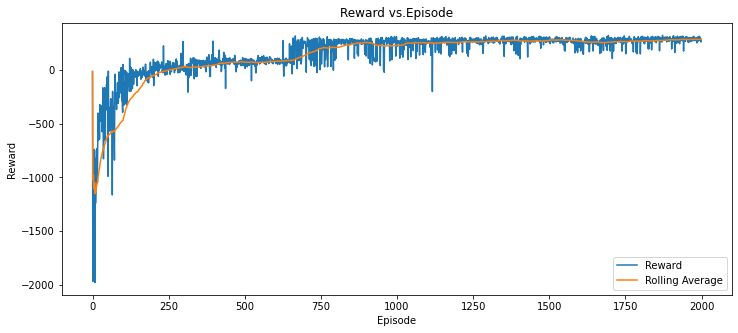

In [31]:
 # Plot the rewards and rolling averages
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(rewards ,label='Reward')
plt.plot(avg_rewards ,label='Rolling Average')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward vs.Episode')
plt.legend()
plt.show()

In [32]:
episode_rewards = np.array(rewards)
episode_rewards.dump(open('TD3_episode_rewards.npy', 'wb'))

avg_rewards = np.array(avg_rewards)
avg_rewards.dump(open('TD3_avg_rewards.npy', 'wb'))